## MIP data analysis.
---
This notebook assumes you have at least one MIPWrangler output file with accompanying sample list located in your **data_directory** and that data directory be bound to /opt/data in the container. i.e. *-B /path/to/your/data_dir/:/opt/data*  

You must have the base_resources directory from the github repository bound to /opt/resources in the container. i.e. *-B /path/to/your/base_resources:/opt/resources*  

You must have the project_resources directory provided separately bound to /opt/projet_resources.
___
You should run each of the code cells in order, using the toolbar above or ctrl+enter.  

If the cell starts with **# RUN**, run the cell with no change.  

If the cell starts with **# USER INPUT**, you **must** specify some parameter before running the cell.  

If the cell starts with **# OPTIONAL USER INPUT**, you may specify some parameter before running the cell. Otherwise the default values specified in the cell will be used.  

In [1]:
# RUN
import sys
sys.path.append("/opt/src")
import mip_functions as mip
import pickle
import json
import copy
import os
import numpy as np
import subprocess
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
wdir = "/opt/analysis/"
data_dir = "/opt/data/"

mip module reloading
functions reloading


### Specify MIPWrangler output file(s).  
When combining more than one sequencing run, the sample list for each run should be in the same order as the MIPWrangler output file. For example, 
```python
info_files = ["sequencing_run_1_wrangler_output.gz", "sequencing_run_2_wrangler_output.gz"]
sample_sheets = ["sample_sheet_for_sequencing_run_1.tsv", "sample_sheet_for_sequencing_run_2.tsv"]
```

In [2]:
# USER INPUT
info_files = ["180828_ASAP_DR1_VAR4_CYTB.txt.gz", ]
sample_sheets = ["180828_samples.tsv"]

In [3]:
# RUN
info_files = [data_dir + i for i in info_files]
sample_sheets = [data_dir + s for s in sample_sheets]

### Preview the sample sheets you provided
Just to have an idea what was included in the sequencing run.

In [4]:
# RUN
pd.concat([pd.read_table(s) for s in sample_sheets],
         ignore_index=True).groupby(["sample_set", "probe_set"]).first()

,,sample_name,replicate,fw,rev,owner,Capture Plate Name,Capture Plate Location,Library Prep
sample_set,probe_set,,,,,,,,
ASAP,"DR1,VAR4,CYTB",ASAP-018-DS,1,193,337,Zack,Zack_mip_captures_ASAP,A01,180828
JJJ,"DR1,VAR4",9172404HS,1,1,97,Travis,Hotspots_P1,A01,180530


### Specify the species and the probe set used
These two are important parameters to determine which files will be used for analysis.  


For the species, the options are: "pf" for *Plasmodium falciparum*, "pv" for *Plasmodium vivax*, "hg19" for *Homo sapiens* genome assembly hg19/GRCh37 and "hg38" for *Homo sapiens* genome assembly hg38/GRCh38  
___
Probe sets also must be specified. Check the output of the above cell under **probe_set** field for a reminder of what the probe set of interest is. This is usually a three letter code or codes separated by a comma.

In [31]:
# USER INPUT
species =  "Change this text with species name. pf, pv, hg19 or hg38"
probe_sets_used = "Probe set here. Something like DR1,VAR4"

In [32]:
# OPTIONAL USER INPUT
##############      SETTINGS FOR DATA FILTERS    ##################$
###################################################################$
###################################################################$
# filters for a haplotype to be considered valid,
# across all samples in an analysis.
# minimum total barcodes
minHaplotypeBarcodes = 0
# minimum number of samples that the haplotype is observed in
minHaplotypeSamples = 0
# minimum fraction of samples that the haplotype is observed in
minHaplotypeSampleFraction = 0
###################################################################$
###################################################################$
# filters for a variant to be considered valid, across all samples $
# an analysis similar to haplotype filters
minVariantBarcodes = 0
minVariantSamples = 0
minVariantSampleFraction = 0
# Phred quality filter for individual variants. This is not used ac$
# but within each sample for each variant.
minVariantQuality = 20
# minimum (within sample) information of a variant to be considered$
# for genotype calling. For example, if minMutationFraction is set $
# and a mutation is at 0.005 frequency in a sample, it'll be called$
# if frequency is between 0.01 and 0.99; it'll be called MIX
# if over 0.99, it'll be called MUT
minMutationFraction = 0.005
# minimum barcode count for a mutation to be considered valid
minMutationCount = 2
minCoverage = 5
# Merge nucleotide changes happening on the same codon to convert t$
# Use only for Plasmodium
mergeSNPs = 1
# minimum (within sample) information of a variant to be considered$
# for genotype calling. For example, if minMutationFraction is set $
# and a mutation is at 0.005 frequency in a sample, it'll be called$
# if frequency is between 0.01 and 0.99; it'll be called MIX
# if over 0.99, it'll be called MUT
minMutationFraction = 0.005
# minimum barcode count for a mutation to be considered valid
minMutationCount = 2
minCoverage = 5
# Merge nucleotide changes happening on the same codon to convert t$
# Use only for Plasmodium
mergeSNPs = 1
# sample_groups is an optional parameter best to leave at the default
# value of *None*. It is included here for advance use cases.
sample_groups = None

### Get/Set the analysis settings
Use the settings template for the species specified to get the  analysis settings and change the vaules specified in the above cell. This will create a template_settings.txt file in your analysis directory and a settings.txt file to be used for the analysis. These files also will serve as a reference of analysis settings for the sake of reproducibility.

In [33]:
# RUN
# Create a list from the probe_sets string
mipSetKey = probe_sets_used.split(",") + [""]
# create a dictionary for which settings should be updated
# using the user specified parameters.
update_keys = {"mipSetKey" : mipSetKey, 
               "minHaplotypeBarcodes": minHaplotypeBarcodes, 
               "minHaplotypeSamples": minHaplotypeSamples,
               "minHaplotypeSampleFraction": minHaplotypeSampleFraction,
               "minVariantBarcodes": minVariantBarcodes,
               "minVariantSamples": minVariantSamples,
               "minVariantQuality": minVariantQuality,
               "minMutationFraction": minMutationFraction,
               "minMutationCount": minMutationCount,
               "minCoverage": minCoverage,
               "mergeSNPs": mergeSNPs,
               "minMutationFraction": minMutationFraction,
               "minMutationCount": minMutationCount,
               "minCoverage": minCoverage,
               "mergeSNPs": mergeSNPs}
# copy the template settings file
temp_settings_file = "/opt/resources/templates/analysis_settings_templates/" + species + "_settings.txt"
subprocess.call(["scp", temp_settings_file, "/opt/analysis/template_settings.txt"])
# extract the settings template
temp_settings = mip.get_analysis_settings("/opt/analysis/template_settings.txt")
# update the settings
for k, v in update_keys.items():
    temp_settings[k] = v
# create a settings file in the analysis directory.
settings_file = "settings.txt"
settings_path = os.path.join(wdir, settings_file)
mip.write_analysis_settings(temp_settings, settings_path)
settings = mip.get_analysis_settings(wdir + settings_file)

### Specify if there is a target file.
Targets file is project specific. Its default location is project_resources/ directory. For a target file project_resources/targets.tsv use:
```Python
targets_file = "/opt/project_resources/targets.tsv" 
```
If targets file is not available, **targets_file = None** should be used.  
```Python
targets_file = None
```

In [35]:
# OPTIONAL USER INPUT
targets_file = None

### Specify how we want to add the "targeted locus" information to experiment results.
You can use:  
1. **target_join=intersection**: Filter variants so that only those in the initial targets list will remain. Annotate the variants with the information from targets file.  
2. **target_join=data**: Keep all variants in the data and annotate.  
3. **target_join=targets**: Keep only the variants in the target list (even if the variant is not observed in the data). This is useful when we're interested in knowing when a variant is not observed, such as drug resistance mutations.  
4. **target_join=union**: Keep all variants, annotate, add variants from targets file even if not observed.

In [1]:
# OPTIONAL USER INPUT
target_join = "intersection"

### Process data, call variants.
Below cell does the rest of the processing. It generates variant files with coverage information, calls genotypes and creates an annotated vcf file using the parameters from the settings file. Some statistics are produced during the process which are saved into the output variable, in case the notebook tab in the browser needs to be closed (since this step can take some time). You can reconnect to your notebook and see the output using the code cell following the process cell.

In [38]:
# RUN
%%capture output
mip.combine_info_files(wdir,
                       settings_file, 
                      info_files,
                      sample_sheets,
                      settings["mipsterFile"])
mip.process_haplotypes(wdir + settings_file)
mip.process_results(wdir,
                    settings_file,
                    [wdir + "samples.tsv"],
                    targets_file=targets_file,
                    target_join=target_join
                   )

45 out of 45 samples has meta information and will be used for analysis.
There are 1724 mapped and 8 unmapped (off target) haplotypes.
There are 3831 data points in raw data, 3823 are mapped to genome and their targets.
Total number of reads and barcodes were 274350 and 218804. On target number of reads and barcodes were 274342 and 218796.
There were 13411 total and 3523 unique variants, 
13411 total and 3523 unique variants remain after filtering variants for minimum total barcodes of 0, minimum observed sample number of 0, and minimum observed sample fraction of 0.0.
11047 total and 2341 unique variants remained after quality filtering for phred scores >= 20.
There are 38 samples with sequence data
There are 45 total samples.
Per sample mutation frequencies have been calculated for mutants with at least 2 supporting barcodes and loci with at least 5 coverage. Loci with less coverage will have NA frequencies and mutants with less supporting barcodes have been reset to zero frequency.


### View the process output

In [ ]:
# RUN
output.show()

### Preview the results
Plotting probe coverage by sample plot is a good  way to see overall experiment perfomance. It shows if a probe has at least 1 barcode for a given sample.  

Dark columns point to poor performing probes whereas dark rows indicate poor samples. Note that this excludes samples with no reads at all. Use "all_barcode_counts.csv" file if those are of interest as well.

Some parameters can be supplied to the plotting function as noted in the comments.

(<Figure size 1800x1200 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5ce12b5a58>)

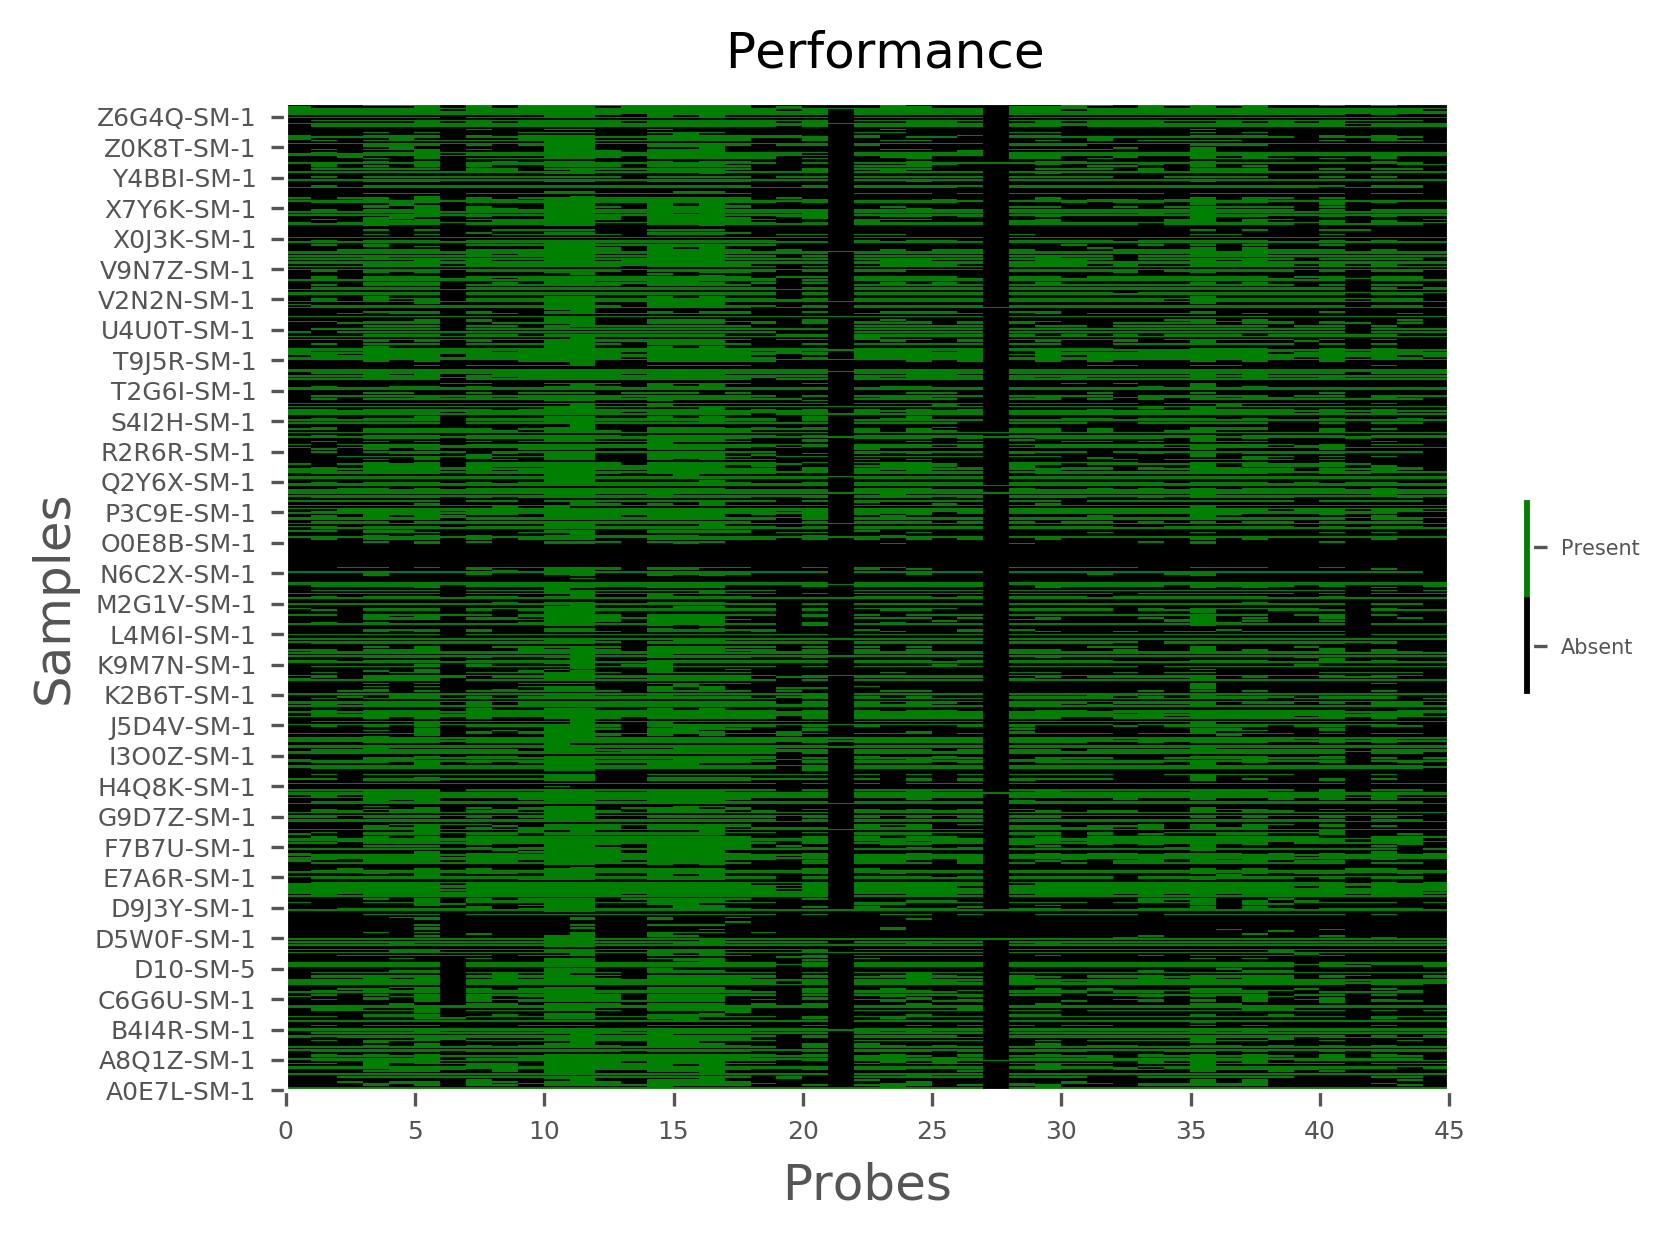

In [23]:
# OPTIONAL USER INPUT
barcode_counts = pd.read_csv(wdir + "barcode_counts.csv",
             header = [0,1], index_col = 0)
mip.plot_performance(barcode_counts,
                     barcode_threshold=1, # anything below this number will be considered absent
                     tick_label_size=8, # font size for tick labels for x and y axis
                     cbar_label_size=5, # font size for heat map color bar
                     dpi=300, # figure resolution
                     absent_color='black',
                     present_color='green,
                     save=False, # If false, plots the graph here. If true, saves a .png in the analysis dir
                    ytick_freq=None, # How frequent the y-axis ticks should be (every nth column will have  a tick)
                    xtick_freq=None,
                    xtick_rotation=90 # x-axis tick label rotation 

There are summary statistics and meta data (if provided) we can use.

In [24]:
# RUN
sample_summary = pd.read_csv(wdir + "sample_summary.csv")
sample_summary.head()

,Sample ID,Read Count,Barcode Count,targets_with_1_barcodes,targets_with_5_barcodes,targets_with_10_barcodes
0,A0E7L-SM-1,29165.0,1479.0,41,39,33
1,A0H8P-SM-1,436.0,95.0,12,5,4
2,A1C8L-SM-1,54268.0,11759.0,44,44,43
3,A1F0G-SM-1,229.0,13.0,3,1,0
4,A1F9P-SM-1,4595.0,314.0,25,15,9


In [29]:
# RUN
meta = pd.read_csv(wdir + "merged_meta.csv")
meta.head()

,Unnamed: 0,Sample ID,Library Prep,sample_name,probe_set,fw,rev,owner,Capture Plate Name,Capture Plate Location,Capture Sample Set,sample_set,Original SID,replicate,Sample Name,Meta
0,0,A0E7L-SM-1,170828,A0E7L,"DR1,CSP",77,89,patrick,SM-Congo-Missing-05,G05,SM,SM,A0E7L-SM-1,1,A0E7L,Meta
1,1,A0H8P-SM-1,170828,A0H8P,"DR1,CSP",31,319,patrick,SM-Congo-Missing-01,C07,SM,SM,A0H8P-SM-1,1,A0H8P,Meta
2,2,A1C8L-SM-1,170828,A1C8L,"DR1,CSP",329,233,patrick,SM-Congo-Missing-04,D05,SM,SM,A1C8L-SM-1,1,A1C8L,Meta
3,3,A1F0G-SM-1,170828,A1F0G,"DR1,CSP",111,15,patrick,SM-Congo-Missing-02,B03,SM,SM,A1F0G-SM-1,1,A1F0G,Meta
4,4,A1F9P-SM-1,170828,A1F9P,"DR1,CSP",213,225,patrick,SM-Congo-Missing-07,B09,SM,SM,A1F9P-SM-1,1,A1F9P,Meta


A scatter plot of total barcode count vs number of probes covered at a certain barcode count is a good way to see how the relationship between total coverage and probe coverage, which is useful in determining how to proceed to the next experiments or analyses.

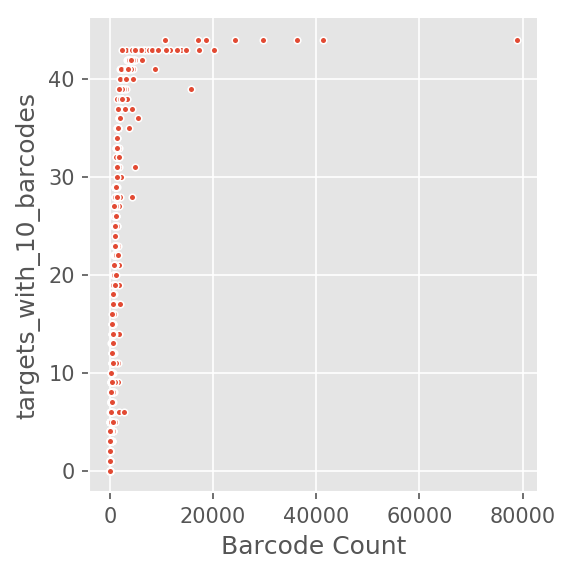

In [28]:
# RUN
f = sns.pairplot(data = sample_summary,
                x_vars = "Barcode Count",
                y_vars = "targets_with_10_barcodes",
                plot_kws={"s": 10})
f.fig.set_size_inches(5,5)
f.fig.set_dpi(150)

### Repooling capture reactions for further sequencing. Factors to consider:
1. What do you we want to accomplish? In most cases, we would like to get enough coverage for a number of probes for each sample. For example, the test data contains **47 probes** in total. Let's say it is sufficient if we had a coverage of **10** or more for each probe for a sample. Then, we would not want to sequence any more of that sample. 
```python
target_coverage_count = 47
target_coverage_key='targets_with_10_barcodes'
```
Alternatively, we can set a goal of a fraction of total probes to reach a certain coverage rather than an absolute number of probes. For 95% of the maximum number of probes observed (47 in this case): 
```python
target_coverage_fraction = 0.95
target_coverage_key='targets_with_10_barcodes'
```
Although we set our goal to 47 probes, it is likely that some sample will never reach that number regardless of how much we sequence, if there is a deletion in the region, for example. So it makes sense to set a total coverage threshold after which we don't expect more data. Looking at the plot above, it seems like after 1000 barcode counts, we would reach our goal for most samples. 
```python
high_barcode_threshold = 10000
```
Another metric to use for determining if we want to sequence a sample more is the average read count per barcode count. This value indicates we have sequenced each unique molecular index in our sample so many times, so when the value is high, it is unlikely that we'd get more UMIs by sequencing the same library more. It makes more sense for a fresh MIP capture from these samples if more data is needed.
```python
barcode_coverage_threshold=10
```
Some samples perform very poorly for one reason or another. There are two options for these samples for repooling consideration: 1) Repool as much as we can for the next run, 2) Assuming there is a problem in the capture reaction, set up a new MIP capture reaction for these samples. It makes more sense to use option 1 if this is the first sequencing data using this library. Use option 2 if this library have been repooled at a higher volume already, but still producing poor data.
```python
barcode_count_threshold=100 # samples below total barcode count of this value is considered low coverage
low_coverage_action='Repool' # what to do for low coverage samples (Repool or Recapture)
```
Sometimes a handful of samples show uneven coverage of loci, i.e. they have very good coverage of a handful of loci but poor coverage in others, which may point to a problem with the sample or the experiment in general. These samples are determined by comparing the subset of samples that reached the goal we set (completed samples) and those that have not. We look at the number of barcodes per probe for _completed_ samples and get 25th percentile (or other percentile as set) and assume that if a sample on average has this many barcodes per target, it should have reached the set goal. For example, if on average _completed_ samples, i.e. samples that cover 47 probes at 10 barcodes or more, have 10000 total barcodes, they would have ~200 (10000/47) barcodes per target covered. And if an _incomplete_ sample has 5000 total barcodes and only 10 targets covered, this value would be 500 for that sample and it would be flagged as **uneven coverage** in repooling document.
```python
assesment_key='targets_with_1_barcodes' # coverage key to compare "complete" and "incomplete" samples
good_coverage_quantile=0.25 # percentile to set the threshold
```

In [32]:
# USER INPUT
high_barcode_threshold = 10000
target_coverage_count = None
target_coverage_fraction = 0.95
target_coverage_key='targets_with_10_barcodes'
barcode_coverage_threshold=10
barcode_count_threshold=100
low_coverage_action='Recapture'
assesment_key='targets_with_1_barcodes'
good_coverage_quantile=0.25

In [35]:
# RUN
data_summary = pd.merge(sample_summary, meta)
mip.repool(wdir, 
           data_summary, 
           high_barcode_threshold, 
           target_coverage_count=target_coverage_count, 
           target_coverage_fraction=target_coverage_fraction, 
           target_coverage_key=target_coverage_key,
           barcode_coverage_threshold=barcode_coverage_threshold,
           barcode_count_threshold=barcode_count_threshold, 
           low_coverage_action=low_coverage_action,
           assesment_key=assesment_key,
           good_coverage_quantile=good_coverage_quantile,
           output_file='repool.csv')

Out of 650 samples 43 are completed, 440 will be recaptured and 167 repooled
24 samples showed uneven coverage, 0 complete, 3 to be recaptured, 21 repooled


### Inspect the repool document
Library to completion field in the repool document has the value (volume) of how much from a sample should be pooled for re-sequencing. These values are only rough estimates and care should be taken to make sure there will be enough material to sequence.

In [37]:
pd.read_csv(wdir + "repool.csv").head()

,Sample ID,Read Count,Barcode Count,targets_with_1_barcodes,targets_with_5_barcodes,targets_with_10_barcodes,Unnamed: 0,Library Prep,sample_name,probe_set,...,replicate,Sample Name,Meta,total_barcode_count,total_read_count,Status,Barcode Coverage,Library to Completion,Barcodes Per Target Covered,Uneven Coverage
0,A0E7L-SM-1,29165.0,1479.0,41,39,33,0,170828,A0E7L,"DR1,CSP",...,1,A0E7L,Meta,1479.0,29165.0,Recapture,19.719405,5.761325,44.818182,False
1,A0H8P-SM-1,436.0,95.0,12,5,4,1,170828,A0H8P,"DR1,CSP",...,1,A0H8P,Meta,95.0,436.0,Recapture,4.589474,104.263158,23.750000,False
2,A1C8L-SM-1,54268.0,11759.0,44,44,43,2,170828,A1C8L,"DR1,CSP",...,1,A1C8L,Meta,11759.0,54268.0,Complete,4.615018,-0.149588,273.465116,False
3,A1F0G-SM-1,229.0,13.0,3,1,0,3,170828,A1F0G,"DR1,CSP",...,1,A1F0G,Meta,13.0,229.0,Recapture,17.615385,768.230769,NaN,False
4,A1F9P-SM-1,4595.0,314.0,25,15,9,4,170828,A1F9P,"DR1,CSP",...,1,A1F9P,Meta,314.0,4595.0,Recapture,14.633758,30.847134,34.888889,False


### Lets look at some files generated from the data
**variant_table.csv** file in your analysis directory contains all the variants passing filters specified in the settings file. The values in the table are each variant's ALT allele barcode depth in a given sample. Note that the value in paranthesis **range(11)** must match the number of header lines in the file. This depends on how many information fields from targets file are retained for final analysis. Experiment with values (9-12) to get the correct value.

In [18]:
var_table = pd.read_csv(
    wdir + "variant_table.csv", 
    header = list(range(11)), index_col = 0
)
var_table.head()

CHROM                            chr1                               \
POS                          266846.0   266867.0          266874.0   
ID                                  .          .                 .   
REF                                 C        Ser                 T   
ALT                                 A        Asn                 A   
Gene                             atp6       atp6              atp6   
Mutation Name              atp6-K776N atp6-S769N        atp6-K767I   
AA Change Position               K776       S769              K767   
ExonicFunc          nonsynonymous SNV       Temp nonsynonymous SNV   
Reference Resistant                No         No                No   
Targeted                           No        Yes                No   
Sample ID                                                            
A0E7L-SM-1                        0.0        0.0               0.0   
A0H8P-SM-1                        0.0        0.0               0.0   
A1C8L-SM-1                        0.0        0.0               0.0   
A1F0G-SM-1                        0.0        0.0               0.0   
A1F9P-SM-1                        0.0        0.0               0.0   

CHROM                                                                \
POS                          266935.0       266936.0       266951.0   
ID                                  .              .              .   
REF                                 G              A              A   
ALT                                 A              G              G   
Gene                             atp6           atp6           atp6   
Mutation Name              atp6-H747Y     atp6-I746I     atp6-T741T   
AA Change Position               H747           I746           T741   
ExonicFunc          nonsynonymous SNV synonymous SNV synonymous SNV   
Reference Resistant                No             No             No   
Targeted                           No             No             No   
Sample ID                                                             
A0E7L-SM-1                        0.0            0.0            0.0   
A0H8P-SM-1                        0.0            0.0            0.0   
A1C8L-SM-1                        0.0            0.0            0.0   
A1F0G-SM-1                        0.0            0.0            0.0   
A1F9P-SM-1                        0.0            0.0            0.0   

CHROM                                                                \
POS                                      266963.0          266968.0   
ID                                              .                 .   
REF                                             T                 G   
ALT                              T              C                 A   
Gene                          atp6           atp6              atp6   
Mutation Name           atp6-T741T     atp6-P737P        atp6-R736C   
AA Change Position            T741           P737              R736   
ExonicFunc          synonymous SNV synonymous SNV nonsynonymous SNV   
Reference Resistant             No             No                No   
Targeted                        No             No                No   
Sample ID                                                             
A0E7L-SM-1                     0.0            0.0               0.0   
A0H8P-SM-1                     0.0            0.0               0.0   
A1C8L-SM-1                     0.0            0.0               0.0   
A1F0G-SM-1                     0.0            0.0               0.0   
A1F9P-SM-1                     0.0            0.0               0.0   

CHROM                                        ...                  chrM  \
POS                          266986.0        ...                4409.0   
ID                                  .        ...                     .   
REF                                 A        ...                     T   
ALT                                 T        ...                     C   
Gene                   

**variant_coverage_table.csv** file has the same structure as the variant_table file. The values in this table has the _total coverage_ for the locus of each variant in each sample.

In [20]:
cov_table = pd.read_csv(
    wdir + "variant_coverage_table.csv", 
    header = list(range(11)), index_col = 0
)
cov_table.head()

CHROM                            chr1                               \
POS                          266846.0   266867.0          266874.0   
ID                                  .          .                 .   
REF                                 C        Ser                 T   
ALT                                 A        Asn                 A   
Gene                             atp6       atp6              atp6   
Mutation Name              atp6-K776N atp6-S769N        atp6-K767I   
AA Change Position               K776       S769              K767   
ExonicFunc          nonsynonymous SNV       Temp nonsynonymous SNV   
Reference Resistant                No         No                No   
Targeted                           No        Yes                No   
Sample ID                                                            
A0E7L-SM-1                       12.0       12.0              12.0   
A0H8P-SM-1                        0.0        0.0               0.0   
A1C8L-SM-1                       48.0       48.0              48.0   
A1F0G-SM-1                        0.0        0.0               0.0   
A1F9P-SM-1                        0.0        0.0               0.0   

CHROM                                                                \
POS                          266935.0       266936.0       266951.0   
ID                                  .              .              .   
REF                                 G              A              A   
ALT                                 A              G              G   
Gene                             atp6           atp6           atp6   
Mutation Name              atp6-H747Y     atp6-I746I     atp6-T741T   
AA Change Position               H747           I746           T741   
ExonicFunc          nonsynonymous SNV synonymous SNV synonymous SNV   
Reference Resistant                No             No             No   
Targeted                           No             No             No   
Sample ID                                                             
A0E7L-SM-1                       42.0           42.0           42.0   
A0H8P-SM-1                        0.0            0.0            0.0   
A1C8L-SM-1                      251.0          251.0          251.0   
A1F0G-SM-1                        0.0            0.0            0.0   
A1F9P-SM-1                        7.0            7.0            7.0   

CHROM                                                                \
POS                                      266963.0          266968.0   
ID                                              .                 .   
REF                                             T                 G   
ALT                              T              C                 A   
Gene                          atp6           atp6              atp6   
Mutation Name           atp6-T741T     atp6-P737P        atp6-R736C   
AA Change Position            T741           P737              R736   
ExonicFunc          synonymous SNV synonymous SNV nonsynonymous SNV   
Reference Resistant             No             No                No   
Targeted                        No             No                No   
Sample ID                                                             
A0E7L-SM-1                    42.0           42.0              42.0   
A0H8P-SM-1                     0.0            0.0               0.0   
A1C8L-SM-1                   251.0          251.0             251.0   
A1F0G-SM-1                     0.0            0.0               0.0   
A1F9P-SM-1                     7.0            7.0               7.0   

CHROM                                        ...                  chrM  \
POS                          266986.0        ...                4409.0   
ID                                  .        ...                     .   
REF                                 A        ...                     T   
ALT                                 T        ...                     C   
Gene                   

We can easily get within sample allele frequency of each variant by dividing variant table by coverage table.  
Note: this table is already generated and in the analysis directory.

In [22]:
freq_table = var_table/cov_table
freq_table.head()

CHROM                            chr1                               \
POS                          266846.0   266867.0          266874.0   
ID                                  .          .                 .   
REF                                 C        Ser                 T   
ALT                                 A        Asn                 A   
Gene                             atp6       atp6              atp6   
Mutation Name              atp6-K776N atp6-S769N        atp6-K767I   
AA Change Position               K776       S769              K767   
ExonicFunc          nonsynonymous SNV       Temp nonsynonymous SNV   
Reference Resistant                No         No                No   
Targeted                           No        Yes                No   
Sample ID                                                            
A0E7L-SM-1                        0.0        0.0               0.0   
A0H8P-SM-1                        NaN        NaN               NaN   
A1C8L-SM-1                        0.0        0.0               0.0   
A1F0G-SM-1                        NaN        NaN               NaN   
A1F9P-SM-1                        NaN        NaN               NaN   

CHROM                                                                \
POS                          266935.0       266936.0       266951.0   
ID                                  .              .              .   
REF                                 G              A              A   
ALT                                 A              G              G   
Gene                             atp6           atp6           atp6   
Mutation Name              atp6-H747Y     atp6-I746I     atp6-T741T   
AA Change Position               H747           I746           T741   
ExonicFunc          nonsynonymous SNV synonymous SNV synonymous SNV   
Reference Resistant                No             No             No   
Targeted                           No             No             No   
Sample ID                                                             
A0E7L-SM-1                        0.0            0.0            0.0   
A0H8P-SM-1                        NaN            NaN            NaN   
A1C8L-SM-1                        0.0            0.0            0.0   
A1F0G-SM-1                        NaN            NaN            NaN   
A1F9P-SM-1                        0.0            0.0            0.0   

CHROM                                                                \
POS                                      266963.0          266968.0   
ID                                              .                 .   
REF                                             T                 G   
ALT                              T              C                 A   
Gene                          atp6           atp6              atp6   
Mutation Name           atp6-T741T     atp6-P737P        atp6-R736C   
AA Change Position            T741           P737              R736   
ExonicFunc          synonymous SNV synonymous SNV nonsynonymous SNV   
Reference Resistant             No             No                No   
Targeted                        No             No                No   
Sample ID                                                             
A0E7L-SM-1                     0.0            0.0               0.0   
A0H8P-SM-1                     NaN            NaN               NaN   
A1C8L-SM-1                     0.0            0.0               0.0   
A1F0G-SM-1                     NaN            NaN               NaN   
A1F9P-SM-1                     0.0            0.0               0.0   

CHROM                                        ...                  chrM  \
POS                          266986.0        ...                4409.0   
ID                                  .        ...                     .   
REF                                 A        ...                     T   
ALT                                 T        ...                     C   
Gene                   

Genotypes are also generated using the threshold values from the settings file. 0: Reference, 1: Mix (Het), 2: Homozygous Alternative

In [41]:
genotypes = pd.read_csv(wdir + "genotypes.csv",
                       header = list(range(4)),
                       index_col = 0)
genotypes.head()

Gene                     PF3D7-1322700                           \
Mutation Name PF3D7-1322700-244_249del PF3D7-1322700-250_255del   
Targeted                            No                       No   
ExonicFunc      nonframeshift deletion   nonframeshift deletion   
Sample ID                                                         
A0E7L-SM-1                         0.0                      0.0   
A0H8P-SM-1                         NaN                      NaN   
A1C8L-SM-1                         0.0                      0.0   
A1F0G-SM-1                         NaN                      NaN   
A1F9P-SM-1                         NaN                      NaN   

Gene                                                             \
Mutation Name PF3D7-1322700-253_265del PF3D7-1322700-256_261del   
Targeted                            No                       No   
ExonicFunc      nonframeshift deletion   nonframeshift deletion   
Sample ID                                                         
A0E7L-SM-1                         0.0                      0.0   
A0H8P-SM-1                         NaN                      NaN   
A1C8L-SM-1                         0.0                      0.0   
A1F0G-SM-1                         NaN                      NaN   
A1F9P-SM-1                         NaN                      NaN   

Gene                                                                    \
Mutation Name PF3D7-1322700-268_279del PF3D7-1322700-A283delinsETYGQNA   
Targeted                            No                              No   
ExonicFunc      nonframeshift deletion         nonframeshift insertion   
Sample ID                                                                
A0E7L-SM-1                         0.0                             0.0   
A0H8P-SM-1                         NaN                             NaN   
A1C8L-SM-1                         1.0                             0.0   
A1F0G-SM-1                         NaN                             NaN   
A1F9P-SM-1                         NaN                             NaN   

Gene                                                               \
Mutation Name PF3D7-1322700-D250N PF3D7-1322700-D250delinsNINGTYD   
Targeted                       No                              No   
ExonicFunc      nonsynonymous SNV         nonframeshift insertion   
Sample ID                                                           
A0E7L-SM-1                    0.0                             0.0   
A0H8P-SM-1                    NaN                             NaN   
A1C8L-SM-1                    0.0                             0.0   
A1F0G-SM-1                    NaN                             NaN   
A1F9P-SM-1                    NaN                             NaN   

Gene                                                                           \
Mutation Name PF3D7-1322700-D262delinsNINGTYD PF3D7-1322700-D274delinsNINGTYD   
Targeted                                   No                              No   
ExonicFunc            nonframeshift insertion         nonframeshift insertion   
Sample ID                                                                       
A0E7L-SM-1                                0.0                             0.0   
A0H8P-SM-1                                NaN                             NaN   
A1C8L-SM-1                                0.0                             0.0   
A1F0G-SM-1                                NaN                             NaN   
A1F9P-SM-1                                NaN                             NaN   

Gene                 ...                              pph                    \
Mutation Name        ...        pph-E1178delinsENNKNNKNNK        pph-I1177T   
Targeted             ...                               No                No   
ExonicFunc           ...          nonframeshift insertion nonsynonymous SNV   
Sample ID            ...                                                      
A0E7L-SM-1          

In [2]:
genotypes.shape

NameError: name 'genotypes' is not defined